# <ins> 5minsNIMROD_vs_RainGauge</ins>

Does NIMROD produce a similar set of AMAX producing events as are found in the rain gauge data?



In [1]:
def create_contingency_table(data, cross_variable_col, quintile_cats, loading_col):  
    data=data.copy()
    data[loading_col] = pd.Categorical(data[loading_col], categories=quintile_cats, ordered=True)
    
    # Create a contingency table
    contingency_table = pd.crosstab(data[cross_variable_col], data[loading_col])

    # Convert counts to row-wise proportions (percentages)
    row_proportional_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Round to 1 decimal place
    row_proportional_table = row_proportional_table.round(1)

    # Calculate the overall proportion for each loading category
    total_counts = contingency_table.sum(axis=0)  # Sum across all duration categories
    overall_proportion = (total_counts / total_counts.sum()) * 100  # Divide by total count to get percentage
    overall_proportion = overall_proportion.round(1)

    # Add the 'All' row to the proportional table
    row_proportional_table.loc['All'] = overall_proportion

    # Convert the proportional table to a list of lists for tabulate
    table_data = row_proportional_table.reset_index().values.tolist()
    headers = ['DurationCategory'] + row_proportional_table.columns.tolist()

    # Print the formatted table using tabulate
    print("Proportional Contingency Table with 'All' Row:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))
    
    
def create_absolute_contingency_table(data, cross_variable_col, quintile_cats,loading_col ):
    data=data.copy()
    data[loading_col] = pd.Categorical(data[loading_col], categories=quintile_cats, ordered=True)
    
    # Create a contingency table with absolute counts
    contingency_table = pd.crosstab(data[cross_variable_col], data[loading_col])

    # Calculate the overall sum for each loading category
    overall_counts = contingency_table.sum(axis=0)  # Sum across all duration categories

    # Add the 'All' row with the overall counts
    contingency_table.loc['All'] = overall_counts

    # Convert the absolute contingency table to a list of lists for tabulate
    table_data = contingency_table.reset_index().values.tolist()
    headers = [cross_variable_col] + list(contingency_table.columns)

    # Print the formatted table using tabulate
    print("Absolute Contingency Table with 'All' Row:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))        

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

sys.path.insert(1, '../')
from Prepare_Events_Functions import *
from Plot_events_functions import *

In [3]:
color_mapping = {
    'F2': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
    'F1': (0.0, 0.6902, 1.0, 0.6), # deepskyblue with 0.6 alpha
    'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
    'B1': (0.8039, 0.0, 0.0, 0.6), # indianred with 0.6 alpha
    'B2': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

color_mapping_seasons = {
    'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
    'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_cats_loading = ['F2','F1', 'C', 'B1', 'B2']
n= 5
quintile_cats_season = ['Winter', 'Summer']    

## Prepare the data
Read in dataframe containing the raw and processed rainfall data, alongside the categorisations

In [4]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_5mins/WholeYear/NIMROD_1km_filtered_100_profiles_df.pkl", 'rb') as f:
    nimrod = pickle.load(f)  

In [5]:
order_duration = ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']

nimrod['DurationRange_notpersonalised'] = pd.Categorical(nimrod["DurationRange_notpersonalised"], categories=order_duration, 
                                                      ordered=True)

Split the data in different ways

In [6]:
nimrod_divisibleby5 = nimrod[nimrod['precip'].apply(is_multiple_of_5)]
nimrod_shortdurations = nimrod[nimrod["duration"]<6]
nimrod_longdurations = nimrod[nimrod["duration"]>=6]
nimrod_shortdurations_divisibleby5 = nimrod_shortdurations[nimrod_shortdurations['precip'].apply(is_multiple_of_5)]
nimrod_longdurations_divisibleby5 = nimrod_longdurations[nimrod_longdurations['precip'].apply(is_multiple_of_5)]
nimrod_summer =nimrod[nimrod["season"]=='Summer']
nimrod_winter =nimrod[nimrod["season"]=='Winter']

In [7]:
print(f"There are {len(nimrod)} NIMROD files")

There are 57367 NIMROD files


### Check the split of AMAX producing events between summer and winter
For each year

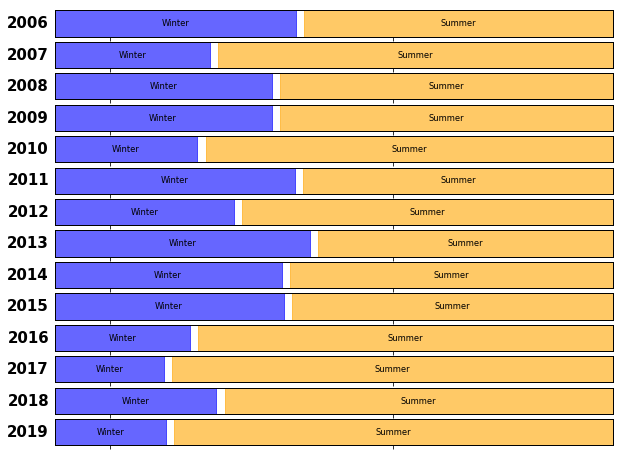

In [8]:
fig, axs = plt.subplots(nrows=14, ncols =1, figsize=(10, 8), sharex=True)
for number, year in enumerate(range(2006,2020)):
    trimmed = nimrod[nimrod['Year'] == year]
    create_single_variable_mosaic_plot(axs[number], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False) 

For events with different characteristics

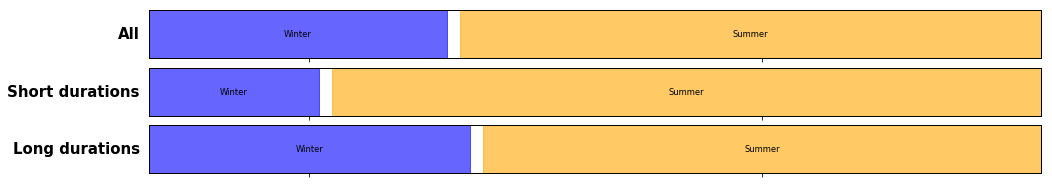

In [9]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 3), sharex=True)  # Adjusted figure size
create_single_variable_mosaic_plot(axs[0], nimrod, 'season', quintile_cats_season, color_mapping_seasons, 'All', False)
create_single_variable_mosaic_plot(axs[1], nimrod_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'Short durations', False)
create_single_variable_mosaic_plot(axs[2], nimrod_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'Long durations', False)

For events in different duration bins

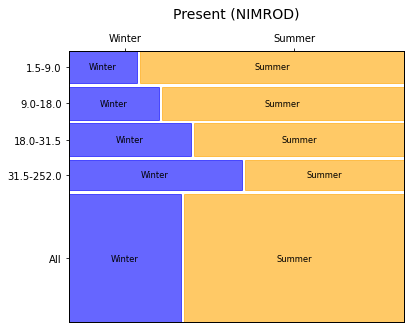

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))
create_mosaic_plot(ax,nimrod , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax.set_title('Present (NIMROD)', fontsize=14, y=1.1);

## Analysis of ways of classifying loading
Choosing only events with a number of data points divisible by 5 the number of events in front loaded categories decreases and the number of events in back loaded categories increases.

### Questions:
- Does normalising the data make a difference to the profile classification?
    - Compare for raw rain, and the interpolated profiles
- Classifying based on the raw data, rather than interpolated profiles, does it make a difference if we just consider profiles of a length divisible by 5?
- Do we get similar results using raw data, for just events divisible by 5, as we do for profiles interpolated to length 15?
    - Can we also check a comparison between events divisible by 5 and those not divisible by 5, for the interpolated profiles
- How different are the results for profiles interpolated to length 12 and length 15?

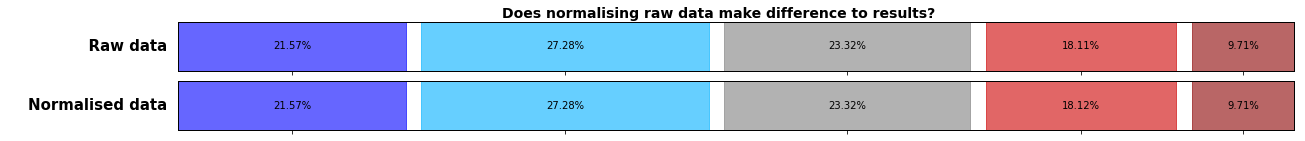

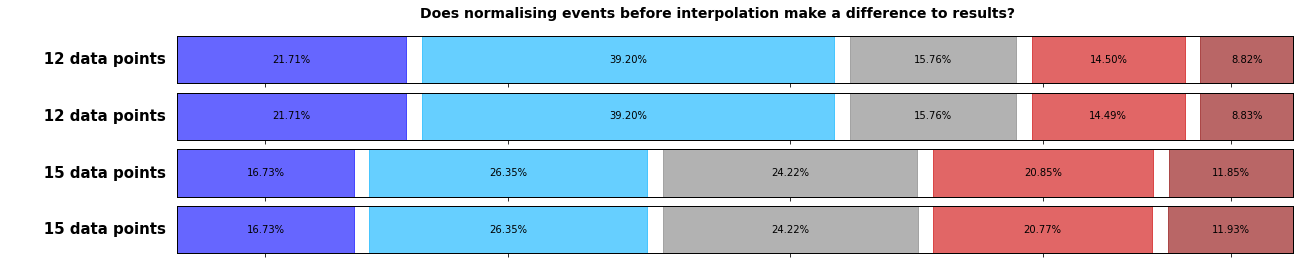

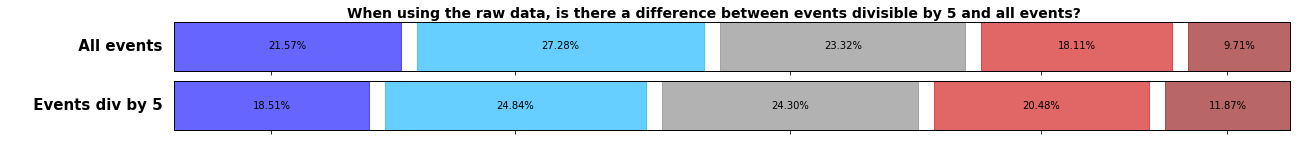

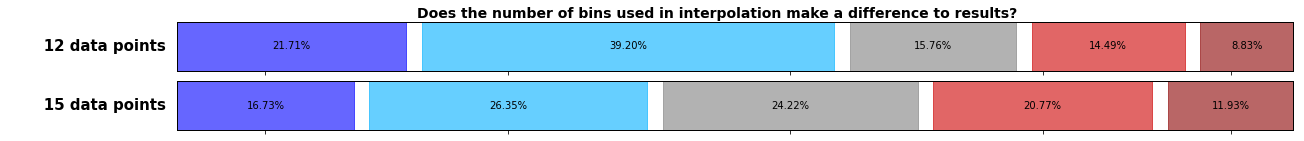

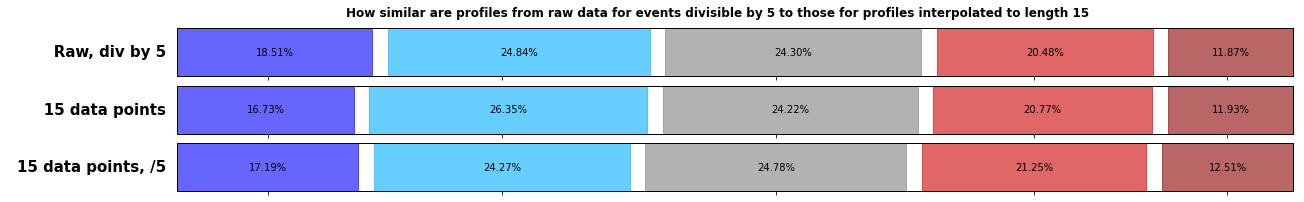

In [11]:
data = nimrod
data_divisibleby5 = nimrod_divisibleby5

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '      Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,  'Loading_profile_normalised_rain',quintile_cats_loading, color_mapping, '    Normalised data', True)
fig.suptitle("Does normalising raw data make difference to results?", fontweight="bold", fontsize=14)

fig, axs = plt.subplots(nrows=4, figsize=(20,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,'Loading_profile_norm_12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data,'Loading_profile15',quintile_cats_loading, color_mapping, '       15 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], data,'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
fig.suptitle('Does normalising events before interpolation make a difference to results?', fontweight="bold", fontsize=14);

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     All events', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data_divisibleby5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     Events div by 5', True)
fig.suptitle("When using the raw data, is there a difference between events divisible by 5 and all events?", fontweight="bold", fontsize=14)

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data, 'Loading_profile_norm_12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data, 'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
fig.suptitle('Does the number of bins used in interpolation make a difference to results?', fontweight="bold", fontsize=14);

fig, axs = plt.subplots(nrows=3, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data_divisibleby5,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '       Raw, div by 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,  'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data_divisibleby5, 'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '15 data points, /5', True)
fig.suptitle('How similar are profiles from raw data for events divisible by 5 to those for profiles interpolated to length 15', fontweight="bold");

In [12]:
create_contingency_table(nimrod, "DurationRange_personalised", quintile_cats_loading, "Loading_profile_norm_12")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+-----+
| DurationCategory |  F2  |  F1  |  C   |  B1  | B2  |
+------------------+------+------+------+------+-----+
|     1.5-9.0      | 27.1 | 38.6 | 14.5 | 12.3 | 7.5 |
|     9.0-18.0     | 26.8 | 35.5 | 14.0 | 13.8 | 9.9 |
|    18.0-31.5     | 21.2 | 39.7 | 16.2 | 14.3 | 8.6 |
|    31.5-252.0    | 11.1 | 43.3 | 18.5 | 17.8 | 9.3 |
|       All        | 21.7 | 39.2 | 15.8 | 14.5 | 8.8 |
+------------------+------+------+------+------+-----+


In [13]:
create_contingency_table(nimrod_shortdurations, "DurationRange_personalised", quintile_cats_loading, "Loading_profile_norm_12")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+-----+
| DurationCategory |  F2  |  F1  |  C   |  B1  | B2  |
+------------------+------+------+------+------+-----+
|     1.5-9.0      | 27.2 | 40.6 | 14.3 | 11.4 | 6.4 |
|       All        | 27.2 | 40.6 | 14.3 | 11.4 | 6.4 |
+------------------+------+------+------+------+-----+


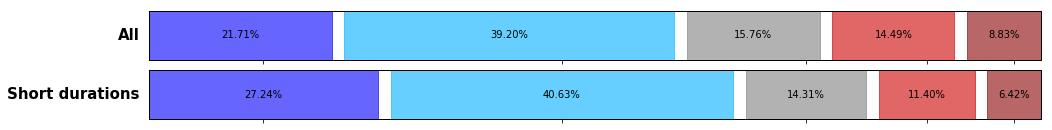

In [14]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod, 'Loading_profile_norm_12',quintile_cats_loading, color_mapping, 'All', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], nimrod_shortdurations, 'Loading_profile_norm_12',quintile_cats_loading, color_mapping, 'Short durations', True)

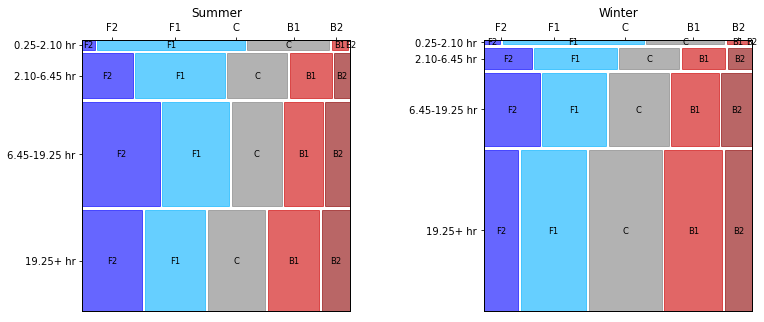

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
create_mosaic_plot(axs[0],nimrod_summer , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain',
                   quintile_cats= quintile_cats_loading, title='Summer', include_all= False, filter_events=True)
create_mosaic_plot(axs[1],nimrod_winter , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain', 
                   quintile_cats= quintile_cats_loading, title='Winter', include_all= False, filter_events=True)

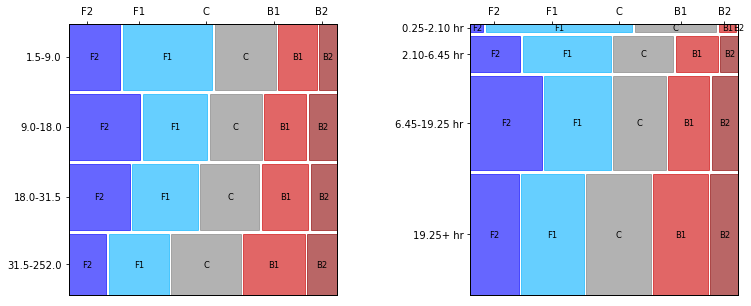

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
create_mosaic_plot(axs[0],nimrod , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats_loading, include_all= False, filter_events=True)
create_mosaic_plot(axs[1],nimrod , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats_loading, include_all= False, filter_events=True)

## Summary profiles

In [17]:
def create_kmeans_centroids(data, num_clusters):
    data=data.copy()
    data = data[data['interpolated15_cumulative_normalized_rainfall'].notna()]
    profiles = np.array(data['interpolated15_cumulative_normalized_rainfall'].tolist())
    # Create and fit the model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(profiles)

    # Get cluster labels for each profile
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return centroids

def plot_centroids(axs, row, centroids, color):
    for num, centroid_cumulative in enumerate(centroids):

        # Time in hours
        time_hours = np.arange(len(centroid_cumulative))  

        # Convert cumulative to intensity (mm/hour)
        intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

        # Calculate average intensity
        average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[0])

        # Normalize intensity by average intensity
        normalized_intensity = intensity / average_intensity

        # Find portion which is heaviest
        # heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)
        quintile_with_max_value = find_quintile_with_max_value(intensity)
        i = quintile_with_max_value
        
        axs[row, i].plot(time_hours[1:], normalized_intensity, color=color, linestyle='-')
        
        if row == 0:
            axs[row, i].set_title(f'Quintile {i + 1}')   

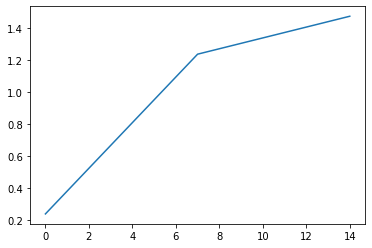

In [18]:
plt.plot(nimrod['interpolated15_cumulative_normalized_rainfall'][3])

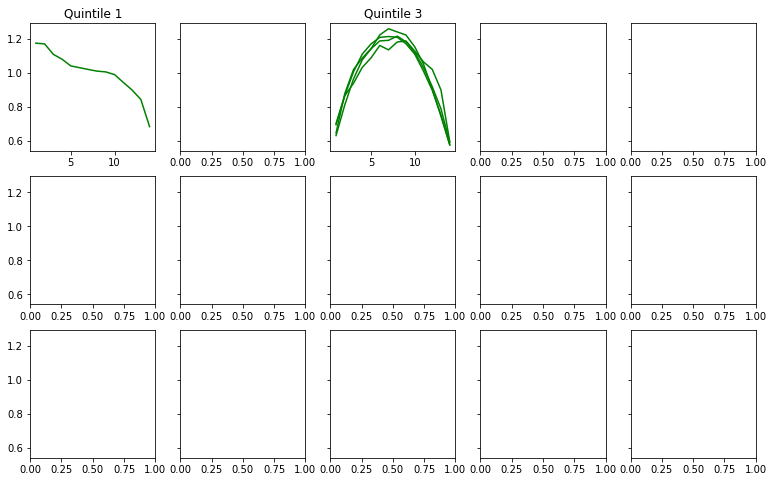

In [19]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(13, 8), sharey=True)

nimrod_centroids_5clusters = create_kmeans_centroids(nimrod, 5)
plot_centroids(axs,0, nimrod_centroids_5clusters, 'green')

# plot_centroids(axs,1, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,1, nimrod_centroids_15clusters, 'black')

# # ukcp18_centroids_15clusters = create_kmeans_centroids(ukcp18_interpolated_profiles, 15)
# # nimrod_centroids_15clusters = create_kmeans_centroids(nimrod_interpolated_profiles, 15)

# plot_centroids(axs,2, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,2, nimrod_centroids_15clusters, 'black')